In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [4]:
df = pd.read_csv('archive/yahoo_stock.csv')

In [131]:
df.drop('Adj Close', axis = 1).describe()

,High,Low,Open,Close,Volume
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09


<AxesSubplot:>

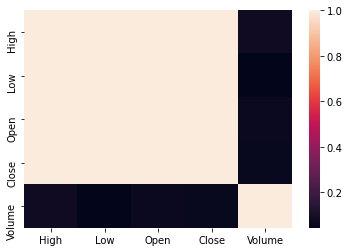

In [134]:
heatmap(df.drop('Adj Close', axis = 1).corr())

In [76]:
df.shape

(1825, 7)

In [18]:
df.Date = pd.to_datetime(df.Date)

# 1. Data Exploration

Text(0, 0.5, 'Stock close price [$]')

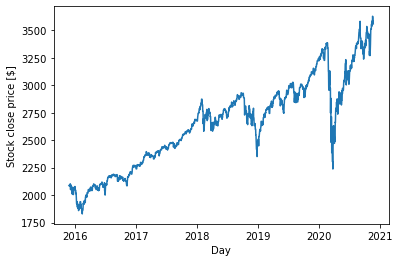

In [40]:
plt.plot(df.Date, df.Close)
plt.xlabel('Day')
plt.ylabel('Stock close price [$]')

In [135]:
df['Year'] = df.Date.dt.year

In [141]:
df[['Year', 'Close']].groupby('Year').mean().reset_

,Close
Year,
2015,2058.875660
2016,2093.592565
2017,2448.491076
2018,2743.891290
2019,2913.895471
2020,3159.985474


# 2. Data Format 
With the 5 previous days:

In [91]:
data = pd.concat([df.Date, df['Adj Close'].shift(5),df['Adj Close'].shift(4), df['Adj Close'].shift(3), df['Adj Close'].shift(2), df['Adj Close'].shift(1), df['Adj Close'].shift(0)], axis = 1).dropna().reset_index(drop=True)
data.columns = ['Date (T)', 'Stock value (T-5)', 'Stock value (T-4)', 'Stock value (T-3)', 'Stock value (T-2)', 'Stock value (T_1)', 'Stock value (T)']

In [92]:
data['Day of week'] = data['Date (T)'].dt.dayofweek
data['month'] = data['Date (T)'].dt.month
data['year'] = data['Date (T)'].dt.year

In [93]:
data

,Date (T),Stock value (T-5),Stock value (T-4),Stock value (T-3),Stock value (T-2),Stock value (T_1),Stock value (T),Day of week,month,year
0,2015-11-28,2086.590088,2089.139893,2088.870117,2088.870117,2090.110107,2090.110107,5,11,2015
1,2015-11-29,2089.139893,2088.870117,2088.870117,2090.110107,2090.110107,2090.110107,6,11,2015
2,2015-11-30,2088.870117,2088.870117,2090.110107,2090.110107,2090.110107,2080.409912,0,11,2015
3,2015-12-01,2088.870117,2090.110107,2090.110107,2090.110107,2080.409912,2102.629883,1,12,2015
4,2015-12-02,2090.110107,2090.110107,2090.110107,2080.409912,2102.629883,2079.510010,2,12,2015
...,...,...,...,...,...,...,...,...,...,...
1815,2020-11-16,3572.659912,3537.010010,3585.149902,3585.149902,3585.149902,3626.909912,0,11,2020
1816,2020-11-17,3537.010010,3585.149902,3585.149902,3585.149902,3626.909912,3609.530029,1,11,2020
1817,2020-11-18,3585.149902,3585.149902,3585.149902,3626.909912,3609.530029,3567.790039,2,11,2020
1818,2020-11-19,3585.149902,3585.149902,3626.909912,3609.530029,3567.790039,3581.870117,3,11,2020


# 3. Split Dataset

In [97]:
X = data.drop(['Date (T)', 'Stock value (T)'], axis = 1)
y = data['Stock value (T)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# 4. Fit Model

In [105]:
model = RandomForestRegressor(n_estimators = 10)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

# 5. Test Model Results

In [106]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(X_test))

0.9954137209208854

In [112]:
y_test.shape

(546,)

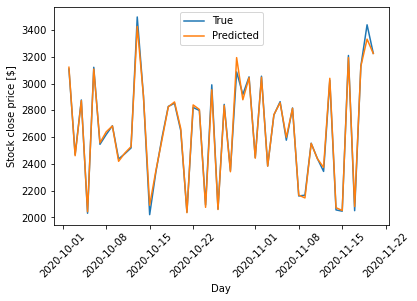

In [126]:
y_pred = model.predict(X_test)

plt.plot(df.Date.tail(50), y_pred[:50], label='True')
plt.plot(df.Date.tail(50), y_test[:50], label='Predicted')

plt.xlabel('Day')
plt.ylabel('Stock close price [$]')
plt.xticks(rotation=45);
plt.legend()

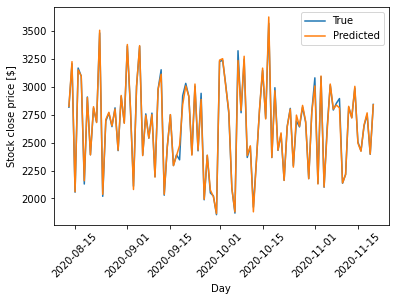

In [143]:
y_pred = model.predict(X_test)

plt.plot(df.Date.tail(100), y_pred[446:], label='True')
plt.plot(df.Date.tail(100), y_test[446:], label='Predicted')

plt.xlabel('Day')
plt.ylabel('Stock close price [$]')
plt.xticks(rotation=45);
plt.legend()

# 6. Feature importance

In [109]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

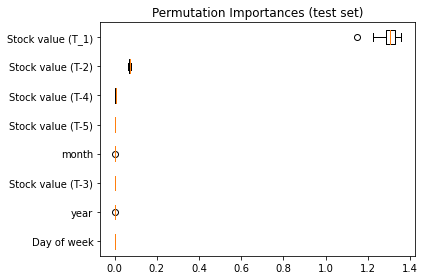

In [110]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()